## VQ-VAE Model

The Vector Quantized-Variational AutoEncoder (VQ-VAE) presents distinct advantages compared to traditional Variational AutoEncoders (VAEs). It employs a discrete latent space, which suits inherently discrete data. VQ-VAE effectively combats posterior collapse, a common issue in VAEs. It excels in generating high-quality samples across various domains, including images, videos, and speech. Its applicability extends to modeling complex data, capturing essential features in multidimensional datasets. Furthermore, VQ-VAE can autonomously learn high-level abstract features from data without supervision, making it a potent tool for tasks requiring discrete data representation and posterior collapse prevention.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset

In [33]:
# Prepare the data
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(trainset, batch_size=32, shuffle=False)

In [34]:
class Encoder(nn.Module):
    def __init__(self, input_channels, hidden_dims):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, hidden_dims[0], kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dims[0], hidden_dims[1], kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv_layers(x)

In [35]:
class Decoder(nn.Module):
    def __init__(self, output_channels, hidden_dims):
        super(Decoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[1], hidden_dims[0], kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dims[0], output_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.conv_layers(z)

In [36]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.K = num_embeddings
        self.D = embedding_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.K, self.D)
        self.embedding.weight.data.uniform_(-1/self.K, 1/self.K)

    def forward(self, inputs):
        # Calculate distances
        input_shape = inputs.shape
        flat_input = inputs.view(-1, self.D)

        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.K, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and calculate loss
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.beta * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        return loss, quantized


In [47]:
class VQVAE(nn.Module):
    def __init__(self, input_channels=1, hidden_dims=[16, 4], num_embeddings=10, embedding_dim=128, beta=0.2):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(input_channels, hidden_dims)
        self.quantizer = VectorQuantizer(num_embeddings, embedding_dim, beta)
        self.decoder = Decoder(input_channels, hidden_dims)

    def forward(self, x):
        z = self.encoder(x)
        loss, quantized = self.quantizer(z)
        x_recon = self.decoder(quantized)
        return x_recon, loss


In [38]:
def train(model, num_epochs=10):

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.to(device)

    # Training loop
    epoch_losses = []
    codebook_vectors_over_epochs = []

    for epoch in range(num_epochs):
        total_loss = 0
        for images, _ in trainloader:
            images = images.to(device)
            optimizer.zero_grad()

            recon_images, quantization_loss = model(images)
            recon_loss = F.mse_loss(recon_images, images)
            loss = recon_loss + quantization_loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        epoch_loss = total_loss / len(trainloader)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

        with torch.no_grad():
            codebook_vectors = model.quantizer.embedding.weight.data.cpu().numpy()
            codebook_vectors_over_epochs.append(codebook_vectors)

    return epoch_losses, codebook_vectors_over_epochs

Epoch 1, Loss: 0.14031054151852926
Epoch 2, Loss: 0.13061330618460973
Epoch 3, Loss: 0.11891313627163569
Epoch 4, Loss: 0.1171928876598676
Epoch 5, Loss: 0.11657933081785837




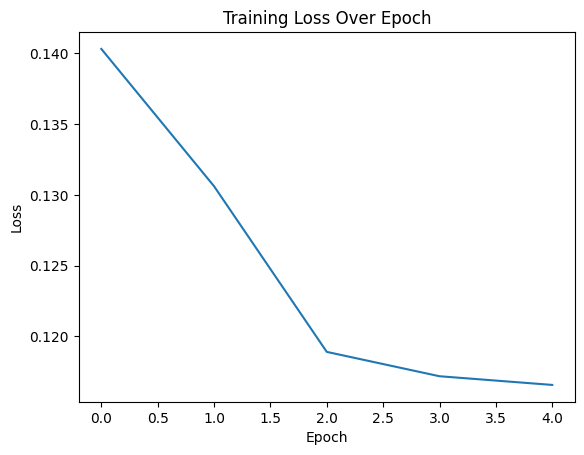

In [44]:
# Model, Optimizer, and Device setup
model = VQVAE(num_embeddings=3, embedding_dim=2, input_channels=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epoch_losses, codebook_vectors_over_epochs = train(model, 5)
print('\n')

# Plotting the training cost over time
plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epoch')
plt.show()

Higher hidden dims gave better results and everything... but I made the model simpler only to achieve your desired output for the coloured section.

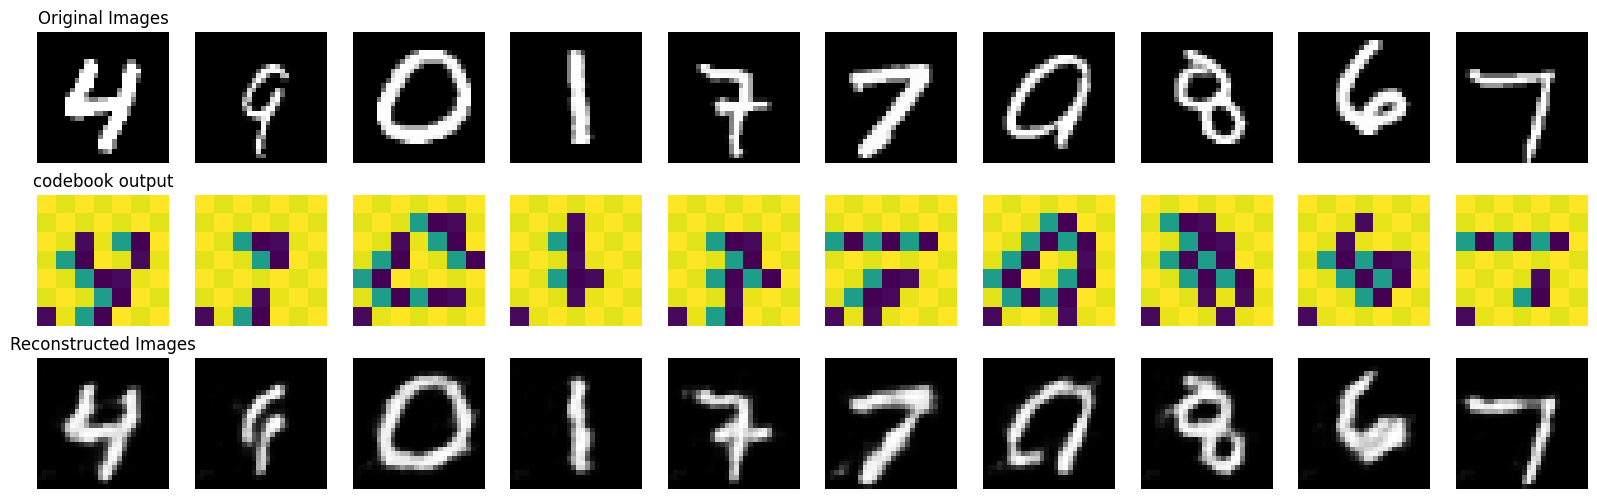

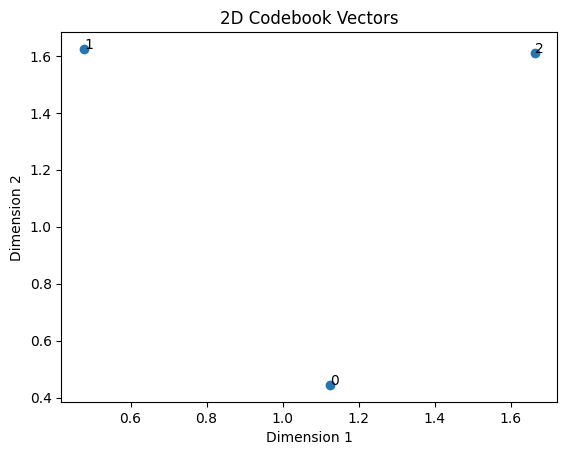

In [69]:
model.eval()

# Visualize some images, their reconstructions, and codebook outputs
images, _ = next(iter(trainloader))
images = images[:10]
images = images.to(device)
with torch.no_grad():
    recon_images, _ = model(images)
    z = model.encoder(images)
    loss, quantized = model.quantizer(z)

# Convert images and reconstructions for visualization
images = images.cpu().numpy()
quantized = quantized.cpu().numpy()
recon_images = recon_images.cpu().numpy()

# Plot original images, 2D scatter plots of quantized latents, and reconstructed images
fig, axes = plt.subplots(3, 10, figsize=(20, 6))  # 3 rows: original, quantized, reconstructed
for i in range(10):
    axes[0, i].imshow(images[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(quantized[i][0].reshape(7, 7))
    axes[1, i].axis('off')

    axes[2, i].imshow(recon_images[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')

axes[0, 0].set_title('Original Images')
axes[1, 0].set_title('codebook output')
axes[2, 0].set_title('Reconstructed Images')
plt.show()
print()

# Visualize the 2D codebook vectors
codebook_vectors = model.quantizer.embedding.weight.data.cpu().numpy()
plt.scatter(codebook_vectors[:, 0], codebook_vectors[:, 1])
for i, vec in enumerate(codebook_vectors):
    plt.text(vec[0], vec[1], str(i), color="black", fontsize=10)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Codebook Vectors')
plt.show()

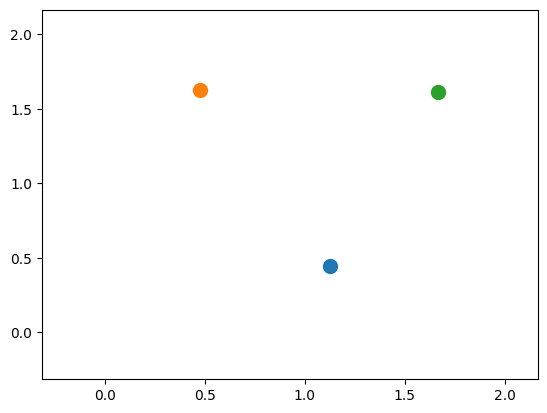

In [70]:
# Create figure for the animation
fig, ax = plt.subplots()
scatters = [ax.scatter([], [], s=100) for _ in range(3)]  # One scatter plot for each codebook vector

# Set plot limits
ax.set_xlim(np.min(codebook_vectors_over_epochs) - 0.5, np.max(codebook_vectors_over_epochs) + 0.5)
ax.set_ylim(np.min(codebook_vectors_over_epochs) - 0.5, np.max(codebook_vectors_over_epochs) + 0.5)

# Animation update function
def update(frame_number):
    data = codebook_vectors_over_epochs[frame_number]
    for scatter, data_point in zip(scatters, data):
        scatter.set_offsets([data_point])
    return scatters

# Animate
gif = FuncAnimation(fig, update, frames=len(codebook_vectors_over_epochs), blit=True, repeat=False)

# Save as GIF
gif.save('/content/codebook_vectors.gif', writer='imagemagick', fps=1)


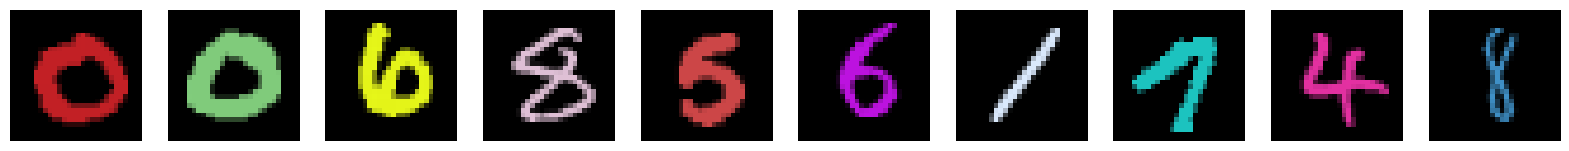

In [26]:
# Define a custom dataset class for Colored MNIST
class ColoredMNIST(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __getitem__(self, index):
        img, target = self.mnist_dataset[index]

        # Apply random color transformations
        colors = [random.uniform(0, 1) for _ in range(3)]
        colored_img = np.stack([img[0, :, :] * color for color in colors], axis=2)

        return torch.tensor(colored_img, dtype=torch.float32).permute(2, 0, 1), target

    def __len__(self):
        return len(self.mnist_dataset)

# Load the standard MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Create the Colored MNIST dataset
colored_trainset = ColoredMNIST(mnist_trainset)
trainloader = DataLoader(colored_trainset, batch_size=32, shuffle=True)

# Fetch a batch of images and plot
images, _ = next(iter(trainloader))
fig, axs = plt.subplots(1, 10, figsize=(20, 4))
for i in range(10):
    axs[i].imshow(images[i].permute(1, 2, 0).numpy(), interpolation='nearest')
    axs[i].axis('off')
plt.show()

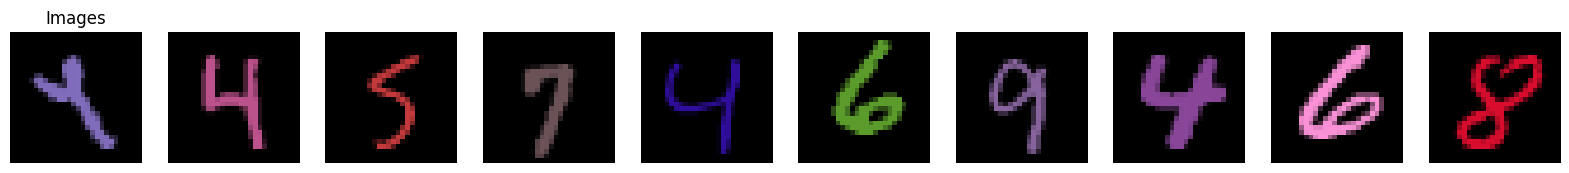

Training with 3 codebook vectors
Epoch 1, Loss: 0.04326536953449249
Epoch 2, Loss: 0.03323213057816029
Epoch 3, Loss: 0.03507128602961699
Epoch 4, Loss: 0.03576360249420007
Epoch 5, Loss: 0.03621825914084911


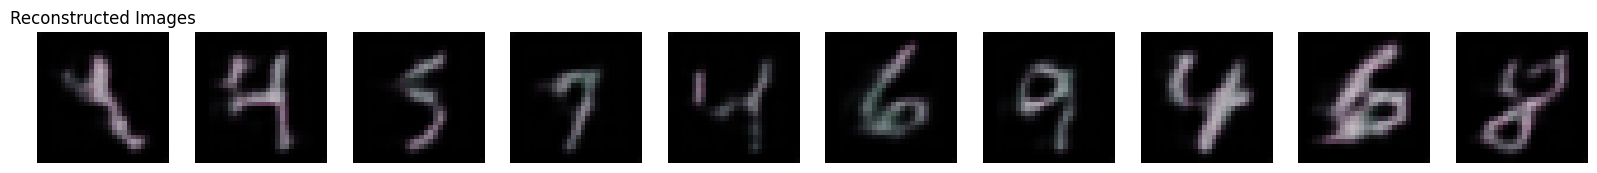

Training with 5 codebook vectors
Epoch 1, Loss: 0.04525604487657547
Epoch 2, Loss: 0.018832561917603016
Epoch 3, Loss: 0.02156798816124598
Epoch 4, Loss: 0.025178268054127692
Epoch 5, Loss: 0.022961280634999276


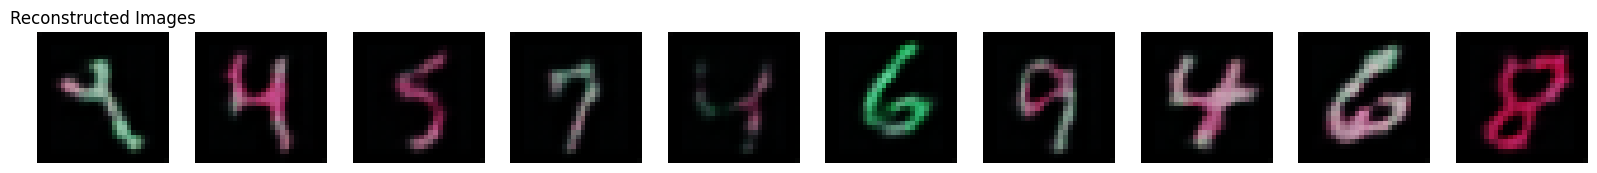

Training with 25 codebook vectors
Epoch 1, Loss: 0.04600760834614436
Epoch 2, Loss: 0.011232102084904909
Epoch 3, Loss: 0.009769021096577247
Epoch 4, Loss: 0.009688421480357647
Epoch 5, Loss: 0.008410799670219422


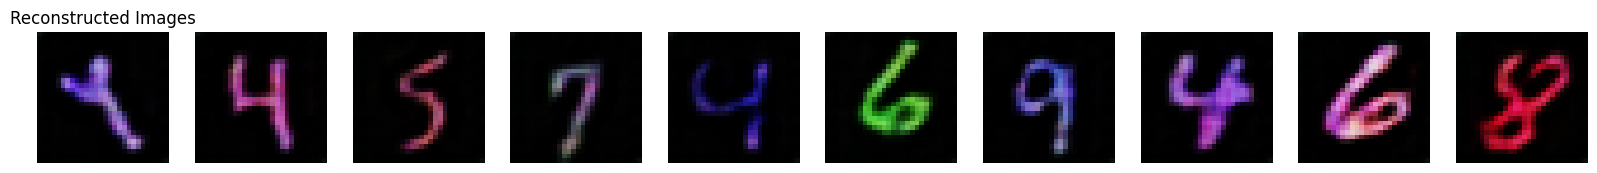

Training with 50 codebook vectors
Epoch 1, Loss: 0.04827870467752218
Epoch 2, Loss: 0.009627619681258996
Epoch 3, Loss: 0.008434741445879142
Epoch 4, Loss: 0.00763818902472655
Epoch 5, Loss: 0.005947397668411334


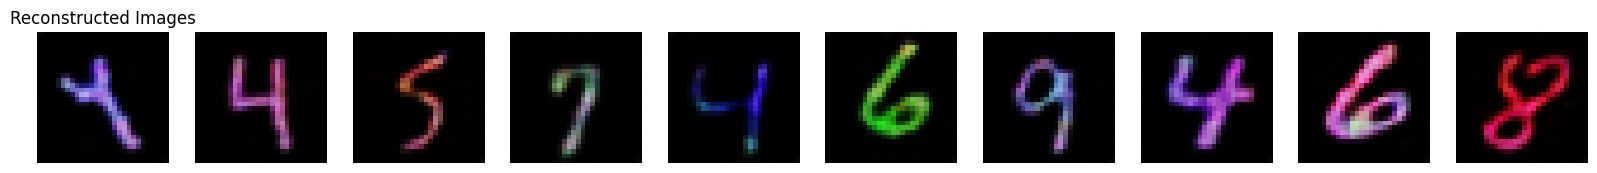

In [27]:
# Define a range of codebook vector sizes
codebook_sizes = [3, 5, 25, 50]

images, _ = next(iter(trainloader))
images = images.to(device)

imagess = images.cpu().numpy()

# Plot images
fig, axes = plt.subplots(1, 10, figsize=(20, 4))
for i in range(10):
    axes[i].imshow(np.transpose(imagess[i], (1, 2, 0)))
    axes[i].axis('off')

axes[0].set_title('Images')
plt.show()

for size in codebook_sizes:
    print(f"Training with {size} codebook vectors")

    # Initialize the VQVAE model with the current number of codebook vectors
    model = VQVAE(num_embeddings=size, embedding_dim=2, input_channels=3).to(device)

    train(model, 5)

    # Visualize original and reconstructed images

    with torch.no_grad():
        recon_images, _ = model(images)

    # Convert images for visualization
    recon_images = recon_images.cpu().numpy()

    # Plot reconstructed images
    fig, axes = plt.subplots(1, 10, figsize=(20, 4))
    for i in range(10):
        axes[i].imshow(np.transpose(recon_images[i], (1, 2, 0)))
        axes[i].axis('off')
    axes[0].set_title('Reconstructed Images')
    plt.show()


Increasing the number of vectors to some point, improves data diversity, resulting in more accurate reconstructions with more details. As its demonstrated in the plots with low number of vectors the model is unable to encode the colors of picture, having a simple architecture. However increasing the vectors to a large number results in full reconstruction with diminishing returns.
Visual improvements are noticeable in colours from small to moderate number of vectors, but increasing the number more causes diminishing returns that may require closer inspection.

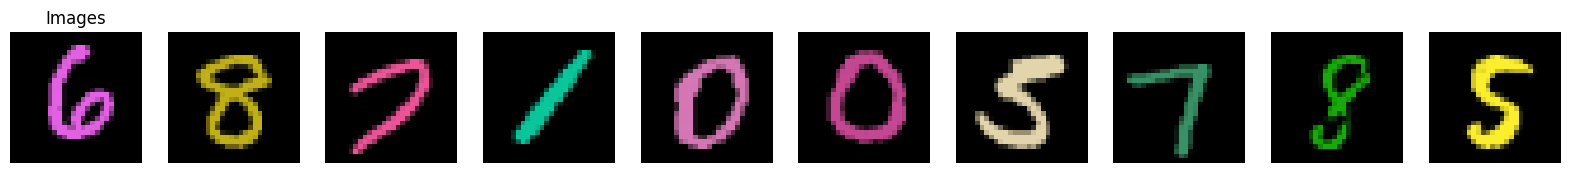

Training with 2D codebook vectors
Epoch 1, Loss: 0.048630161982774735
Epoch 2, Loss: 0.0312215090572834
Epoch 3, Loss: 0.032615402274330456
Epoch 4, Loss: 0.03255776708126068
Epoch 5, Loss: 0.03288222400744756


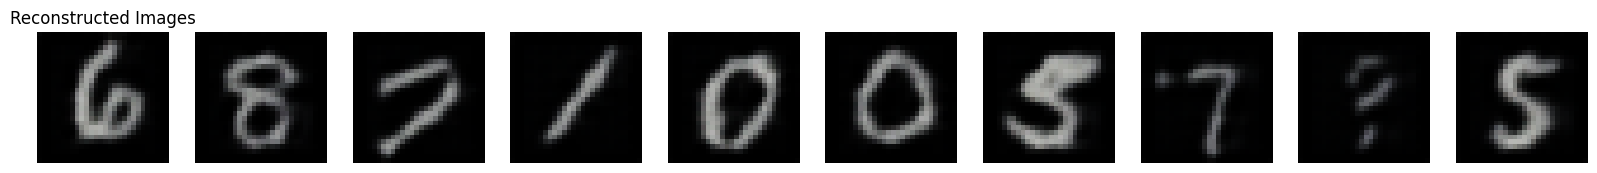

Training with 16D codebook vectors
Epoch 1, Loss: 0.11457659108440081
Epoch 2, Loss: 0.2124991625348727
Epoch 3, Loss: 0.2596576858838399
Epoch 4, Loss: 0.277659657629331
Epoch 5, Loss: 0.285489700905482


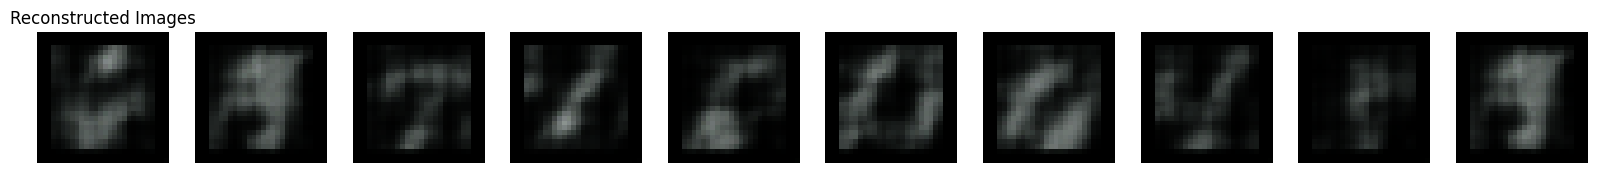

Training with 32D codebook vectors
Epoch 1, Loss: 0.12676026660998663
Epoch 2, Loss: 0.181482288702329
Epoch 3, Loss: 0.21422311408519745
Epoch 4, Loss: 0.2105907896677653
Epoch 5, Loss: 0.18135987668037415


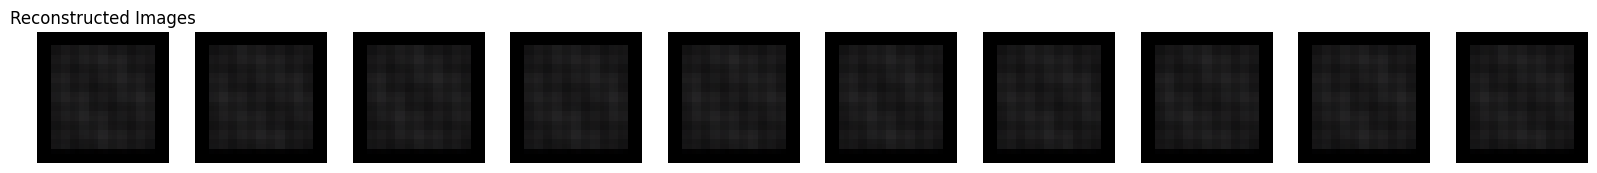

In [32]:
# Define a range of codebook vector sizes
codebook_dims = [2, 16, 32]

images, _ = next(iter(trainloader))
images = images.to(device)

imagess = images.cpu().numpy()

# Plot images
fig, axes = plt.subplots(1, 10, figsize=(20, 4))
for i in range(10):
    axes[i].imshow(np.transpose(imagess[i], (1, 2, 0)))
    axes[i].axis('off')

axes[0].set_title('Images')
plt.show()

for dim in codebook_dims:
    print(f"Training with {dim}D codebook vectors")

    # Initialize the VQVAE model with the current number of codebook vectors
    model = VQVAE(embedding_dim=dim, num_embeddings=3, input_channels=3).to(device)

    train(model, 5)

    # Visualize original and reconstructed images

    with torch.no_grad():
        recon_images, _ = model(images)

    # Convert images for visualization
    recon_images = recon_images.cpu().numpy()

    # Plot reconstructed images
    fig, axes = plt.subplots(1, 10, figsize=(20, 4))
    for i in range(10):
        axes[i].imshow(np.transpose(recon_images[i], (1, 2, 0)))
        axes[i].axis('off')
    axes[0].set_title('Reconstructed Images')
    plt.show()


Increasing the embedding dimension while keeping the number of embedding vectors small, as illustrated above, results in worse reconstruction quality due to overparameterization, sparse coverage and having learning difficulties. There are too many dimensions to effectively capture the diversity of the data with the limited number of vectors available. Thus, he vectors don't adequately cover the space and the model struggles to learn meaningful representations.